In [76]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [77]:
import numpy as np
import pandas as pd

In [78]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [79]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [80]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [81]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [82]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [83]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [84]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

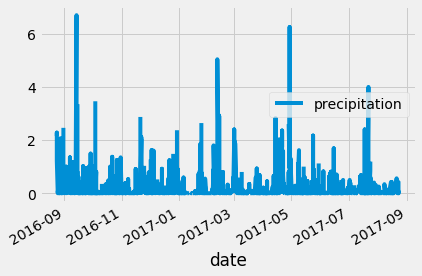

In [85]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date)
qry = session.query(func.max(Measurement.date).label("max_date"))
res = qry.one()
end_date = res.max_date

# Calculate the date 1 year ago from the last data point in the database
max_range = dt.datetime.strptime(end_date, '%Y-%m-%d')
start_date = max_range.replace(max_range.year-1)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= start_date, 
                                       Measurement.date <= end_date)

# Save the query results as a Pandas DataFrame and set the index to the date column
weather_df = pd.read_sql(results.statement, results.session.bind)
weather_df['date']=pd.to_datetime(weather_df['date'])
weather_df=weather_df.set_index('date').rename(columns={"prcp":"precipitation"})

# Sort the dataframe by date
weather_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
weather_df.plot()
plt.show()

In [86]:
# Use Pandas to calcualte the summary statistics for the precipitation data
pd.DataFrame(weather_df.describe())

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [87]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct(Measurement.station).count()

9

In [88]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f"Most Active Station: {active[0]}")
print("\n#################################\nList of active stations by order\n#################################")
my_print=[print(f"{val}") for val in active]


Most Active Station: ('USC00519281', 2772)

#################################
List of active stations by order
#################################
('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [89]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
my_res = session.query(Measurement.station,func.min(Measurement.tobs).label("low_temp"),
              func.max(Measurement.tobs).label("high_temp"),
              func.avg(Measurement.tobs).label("mean_temp")).filter(Measurement.station==active[0][0])

values=my_res.all()
print(f"The most active station is: {values[0][0]}")
print(f"Its lowest temperature is: {values[0][1]}")
print(f"Its highest temperature is: {values[0][2]}")
print(f"Its average temperature is: {values[0][3]}")

The most active station is: USC00519281
Its lowest temperature is: 54.0
Its highest temperature is: 85.0
Its average temperature is: 71.66378066378067


In [90]:
session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
            order_by(func.count(Measurement.tobs).desc()).first()[0]

'USC00519281'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002712737CD68>]],
      dtype=object)

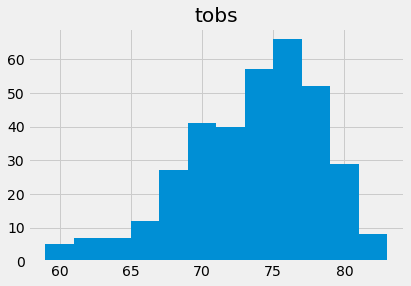

In [91]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_ht = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
            order_by(func.count(Measurement.tobs).desc()).first()[0]
stat_temp = session.query(Measurement.tobs).filter(Measurement.date >= start_date, 
                                       Measurement.station==station_ht).all()
temp_df = pd.DataFrame(stat_temp)
temp_df.hist(bins=12)

In [92]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [93]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_out = calc_temps('2017-02-01', '2017-02-28')
calc_out

[(59.0, 69.89265536723164, 80.0)]

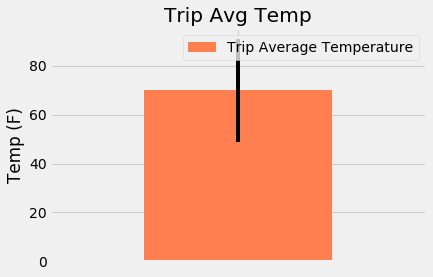

In [94]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
visit_dict = {"Trip Average Temperature": calc_out[0][1], "yerr":calc_out[0][2] - calc_out[0][0]}#pd.DataFrame({"Trip Average Temperature": calc_out[0][1], "yerr":calc_out[0][2] - calc_out[0][0]})
visit_df = pd.DataFrame(pd.Series(visit_dict)).T
plt.Figure(figsize=(0.9,1))
ax = visit_df[["Trip Average Temperature"]].plot(kind = 'bar',yerr = visit_df['yerr'],color="coral")
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
ax.set_xticklabels([''])
plt.show()

In [95]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rain= session.query(Measurement.station,func.sum(Measurement.prcp).label('total_rain')).group_by(Measurement.station)\
                    .filter(Measurement.date >= start_date).subquery()

# print(rain)
station_rain = session.query(Station.station,Station.name, Station.latitude, Station.longitude, Station.elevation,\
                             rain.c.total_rain).join(rain,Station.station==rain.c.station)\
                .order_by(rain.c.total_rain.desc())
print(station_rain)
station_rain.all()

SELECT station.station AS station_station, station.name AS station_name, station.latitude AS station_latitude, station.longitude AS station_longitude, station.elevation AS station_elevation, anon_1.total_rain AS anon_1_total_rain 
FROM station JOIN (SELECT measurement.station AS station, sum(measurement.prcp) AS total_rain 
FROM measurement 
WHERE measurement.date >= ? GROUP BY measurement.station) AS anon_1 ON station.station = anon_1.station ORDER BY anon_1.total_rain DESC


[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  147.11000000000004),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  68.24000000000002),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  48.36000000000003),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  37.99),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  33.19),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  16.089999999999986),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 4.59)]

## Optional Challenge Assignment

In [96]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [97]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.datetime(2017,2,1)
# start_date =  start_date + dt.timedelta(days=1)
# print(start_date)
end_date = dt.datetime(2017,2,28)
# print(end_date)
# Use the start and end date to create a range of dates
list_trip_dates = [dt.datetime.strptime(f"{start_date.year}-{start_date.month}-{d}", '%Y-%m-%d').date()\
                   for d in range(start_date.day, end_date.day+1)]
# print(list_trip_dates)
# Stip off the year and save a list of %m-%d strings
list_trip_m_d = [ f'{d.strftime("%m")}-{d.strftime("%d")}' for d in list_trip_dates]
# print(list_trip_m_d)
# Loop through the list of %m-%d strings and calculate the normals for each date
list_d_normals = [daily_normals(i) for i in list_trip_m_d]
# list_d_normals = [list_d_normals[d[0]] for d[0] in list_d_normals]
print(list_d_normals)
# [d[0] for d in list_d_normals]

[[(56.0, 68.14035087719299, 78.0)], [(59.0, 68.85964912280701, 77.0)], [(58.0, 67.79661016949153, 77.0)], [(61.0, 68.14035087719299, 76.0)], [(59.0, 69.6842105263158, 80.0)], [(58.0, 70.38983050847457, 77.0)], [(60.0, 69.0, 77.0)], [(56.0, 66.75438596491227, 74.0)], [(57.0, 67.58928571428571, 75.0)], [(56.0, 68.41666666666667, 76.0)], [(61.0, 69.25, 79.0)], [(60.0, 69.15789473684211, 78.0)], [(58.0, 70.36206896551724, 80.0)], [(62.0, 70.89473684210526, 79.0)], [(56.0, 70.28813559322033, 79.0)], [(59.0, 70.48214285714286, 76.0)], [(62.0, 70.47272727272727, 77.0)], [(63.0, 70.79629629629629, 77.0)], [(60.0, 69.33962264150944, 77.0)], [(63.0, 70.14035087719299, 76.0)], [(63.0, 69.79629629629629, 76.0)], [(60.0, 70.15789473684211, 83.0)], [(62.0, 70.35593220338983, 81.0)], [(61.0, 68.56666666666666, 76.0)], [(61.0, 68.59649122807018, 76.0)], [(62.0, 69.89285714285714, 78.0)], [(58.0, 69.98148148148148, 77.0)], [(65.0, 70.65517241379311, 80.0)]]


In [98]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
final_dn = zip(list_trip_dates, list_d_normals)
# print(dict(final_dn))
df_daily_normals=pd.DataFrame(data=dict(final_dn)).T
tmin = []
tave = []
tmax = []
for index in range(0,len(df_daily_normals.index)):
    tmin.append(df_daily_normals.iloc[index][0][0])
    tave.append(df_daily_normals.iloc[index][0][1])
    tmax.append(df_daily_normals.iloc[index][0][2])

df_daily_normals['tmin']=tmin
df_daily_normals['tave']=tave
df_daily_normals['tmax']=tmax
df_daily_normals.drop(0,axis=1,inplace=True)
df_daily_normals.index.names = ['date']
df_daily_normals.head()

,tmin,tave,tmax
date,,,
2017-02-01,56.0,68.140351,78.0
2017-02-02,59.0,68.859649,77.0
2017-02-03,58.0,67.796610,77.0
2017-02-04,61.0,68.140351,76.0
2017-02-05,59.0,69.684211,80.0


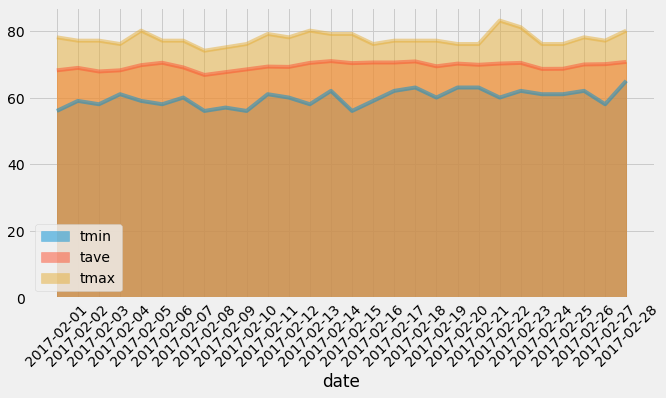

In [99]:
# Plot the daily normals as an area plot with `stacked=False`
ax=df_daily_normals.plot.area(stacked=False,figsize=(10,5))
ax.set_xticklabels(df_daily_normals.index.values,rotation=45)
ax.set_yticks(range(0,100,20))
ax.set_yticklabels(range(0,100,20))
ax.set_xticks(df_daily_normals.index.values)
plt.show()